# Example of RC for Lorenz 1963 System

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from scipy import stats

sys.path.insert(1, '../')
#import reservoir and system code
from reservoir import *
from system import *

First we define and analyse the system we're trying to predict.  Here we have the lorenz 1963 system.

In [2]:
sigma = 10   # Prandlt number
rho = 28     # Rayleigh number
beta = 8.0/3

D = 3

#lorenz63 model
def lorenz(n, t, p):
    sigma, rho, beta = p
    x, y, z = n
    dxdt = sigma*(y-x)
    dydt = x*(rho-z)-y
    dzdt = x*y - beta*z
    dXdt = [dxdt, dydt, dzdt]
    return dXdt

def jac(X, t, p):
    sigma, rho, beta = p
    x, y, z = X
    return np.array([[-sigma, sigma, 0],
                     [-z+rho, -1, -x],
                     [y, x, -beta]])

# build the system from the dynamical equations
# jacobian is not necessary if you do not care about the lyapunov exp
lor63sys = system(lorenz, (sigma, rho, beta), D, 0.001, fjac = jac)

Now we integrate the system to define the function that we feed to the reservoir.  Make sure that the system is defined for negative times in order to synchronize the reservoir and is defined far enough in the future to enable comparison to the prediction.

In [3]:
%%time
t, u = lor63sys.integrate(-100, 200)

CPU times: user 336 ms, sys: 7.18 ms, total: 343 ms
Wall time: 344 ms


## System analysis

Next we do some analysis of the system.

1) Find the embedding dimension for the input system

2) Find the lyapunov exponents for the system

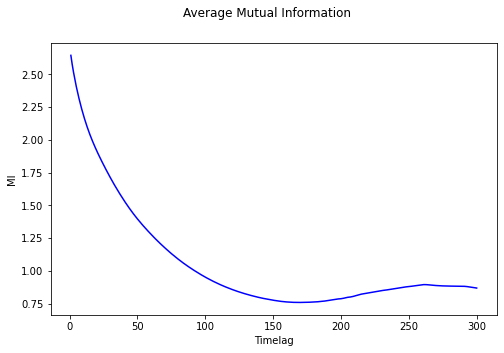

Enter a number up to search for first minimum
end search: 250
The first min of MI is: T=168


168

In [4]:
# Here we find the optimal time delay by getting the first minumum of
# the average mutual information of the time delayed system.
lor63sys.findMinAMI(0.3)

To find the embedding dimension for the data we run the false nearest neighbors algorithm

In [5]:
%%time
lor63sys.FNN(6)

[100.    8.2   0.    0.    0.    0. ]
minimum embedding dimension is 3 with NFNN 0.004
CPU times: user 21.9 s, sys: 2.48 s, total: 24.4 s
Wall time: 22.3 s


### Lyapunov Exponents

We can get the global lyapunov exponents of the system using the globalLyap function.  For differentiable systems such as the ones defined here one of the exponents should trend to 0. If it does not then you should run the algorithm for a longer time

In [9]:
%%time
#standard values: [0.9056 0 −14.5721]
LE = lor63sys.globalLyap(150, 1)
print(np.round(LE, 3))

Integrating system for LE calculation...
Computing LE spectrum...
done
[ 9.0000e-01 -3.0000e-03 -1.4551e+01]
CPU times: user 5.56 s, sys: 31.3 ms, total: 5.59 s
Wall time: 5.61 s


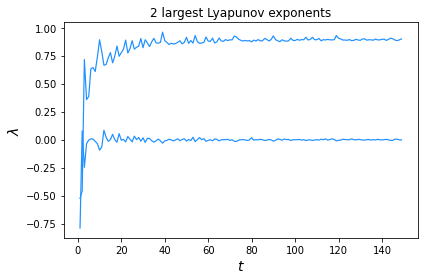

In [10]:
lor63sys.plotLE(2) #should show convergence

In [11]:
lor63sys.getKYDim()

2.0616822150236955

## Local Exponents

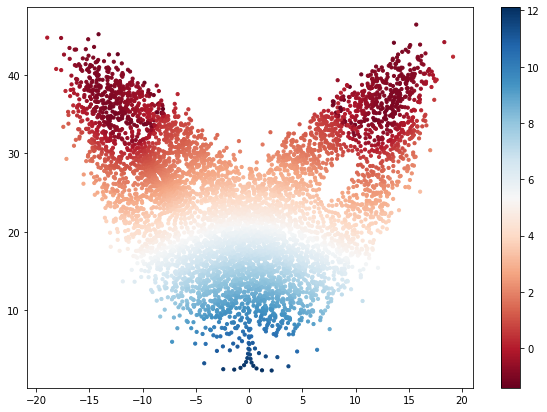

In [12]:
%%time
L = 2
dt = 0.05
skip = 50
scat = u[::skip]
LE = lor63sys.localExp(scat, L, dt, multi = True)
fig = plt.figure(figsize = (10, 7))
plt.scatter(scat[:, 0], scat[:, 2], s = 10, c = LE[:, 0], cmap = 'RdBu')
plt.colorbar()

## Reservoir Prediction

Now we define the parameters for our reservoir.  The performance of the reservoir is very dependent on the parameters and the parameters depend on the system.

Make sure D (dimension) is the same as for the input system

In [13]:
N = 2000
sigma = 0.014

# dr/dt = gamma * (-r + tanh(M*r+Win*u))
params = {'name': 'Lor63_N2000',
          'N': N, #number of neurons
          'D': D, #dimension of the input system
          'gamma': 10, #time constant for the system
          'M_a': -1, #M connectivity matrix lower bound
          'M_b': 1, #M connectivity matrix upper bound
          'M_pnz': 0.02, #M connectivity matrix sparsity
          'M_SR': 0.9, #M connectivity matrix spectral radius
          'Win_a': -sigma, #Win input matrix lower bound
          'Win_b': sigma, #Win input matrix upper bound
          'time_step': 0.002, #integration time step for reservoir
          'spinup_time': 10, #time it takes to synchronize res with sys
          'system': lor63sys, #system to run reservoir over
          'saveplots': False} #save the plots

#build the reservoir
lor63Res = reservoir(params)

### Training step

To train the reservoir we need to

1) define function Q s.t. Wout Q(r) = u

2) define constraints on Wout if needed

In [14]:
%%time
def Q(r): return np.hstack((r, np.power(r, 2)))

train_time = 60
train_time_step = 0.02
beta = 1e-6

#optional parameter, must be integers
constraints = [[(0, N)],
               [(0, N)],
               [(0, N//2), (3*N//2, 2*N)]]

#takes significantly longer when get_jac = True
data, Jac_est, Jac = lor63Res.train(train_time, #time to train the reservoir
                                    train_time_step, #time step over which to train (> integration time step)
                                    Q,
                                    beta,
                                    constraints = constraints,
                                    get_jac = False)

CPU times: user 1min 58s, sys: 1.36 s, total: 1min 59s
Wall time: 32.1 s


In [15]:
lor63Res.rmsd #root mean square deviation

0.04961208319368898

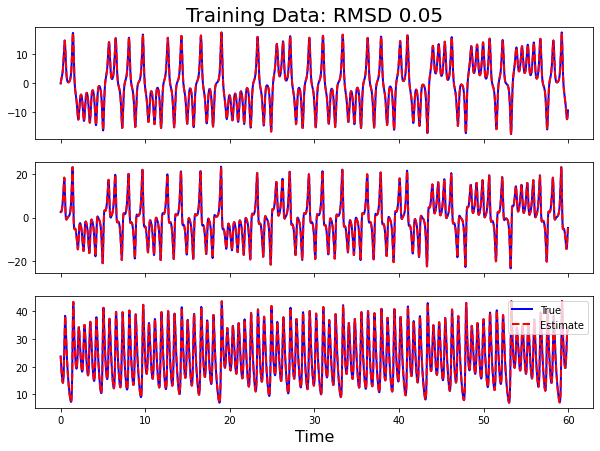

In [16]:
lor63Res.plotTraining()

In [17]:
lor63Res.Wout

array([[ 0.30581522,  0.35559517,  0.03846586, ...,  0.        ,
         0.        ,  0.        ],
       [ 9.07945037,  5.81291926, -1.24872696, ...,  0.        ,
         0.        ,  0.        ],
       [-0.97864819, -2.03331661, -2.84056664, ...,  0.50502342,
         1.40421009,  0.01707387]])

### Prediction step

Here we predict forward in time using the Wout given by the training data.  The first time point is at the end of a period of time where we synchronize the system and the reservoir. The prediction follows the true trajectory closely until it eventually diverges due to the chaotic nature of the Lorenz attractor.  The vertical line gives a numerical estimate of where the trajectories start to diverge.

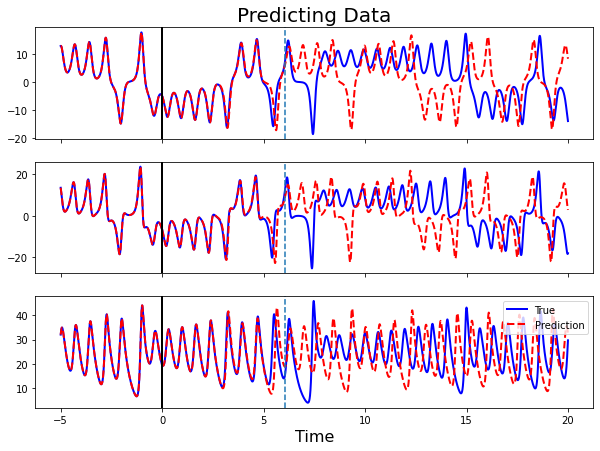

CPU times: user 37.1 s, sys: 473 ms, total: 37.5 s
Wall time: 10.7 s


6.058

In [19]:
%%time
# lor63Res.ifsave = True
acc = 3
lor63Res.predict(20, acc = acc)

Text(0.5, 1.0, 'Error')

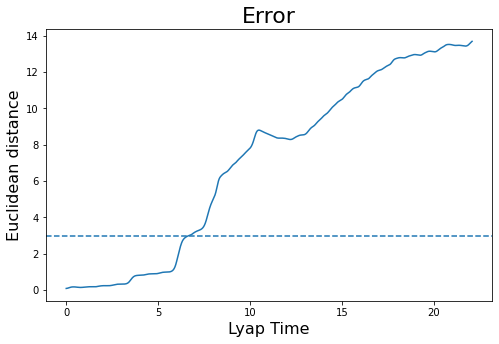

In [20]:
fig = plt.figure(figsize = (8, 5))
plt.plot(lor63Res.pred_t/0.9056, np.cumsum(lor63Res.diff)/np.arange(1, len(lor63Res.diff)+1))
plt.axhline(acc, ls = '--')
plt.xlabel('Lyap Time', fontsize = 16)
plt.ylabel('Euclidean distance', fontsize = 16)
plt.title('Error', fontsize = 22)
# fig.savefig('euc_dist.pdf', bbox_inches = 'tight')

### Prediction variation

In [24]:
lyap = 0.9056
n = 1000
pred = np.zeros(n)
x = np.zeros((n,lor63sys.D))
for i in range(n):
    pred[i] = lor63Res.predict(15, acc = 1, show = False)
    x[i] = lor63Res.predSysx0
pred = pred/lyap
np.savez('results/pred_var.npz', x = x, pred = pred)

In [25]:
pred = np.load('results/pred_var.npz')['pred']
x = np.load('results/pred_var.npz')['x']

In [40]:
L = 64
dt = 0.05
T = L*dt
LE = lor63sys.localExp(x, L, dt, multi = True)

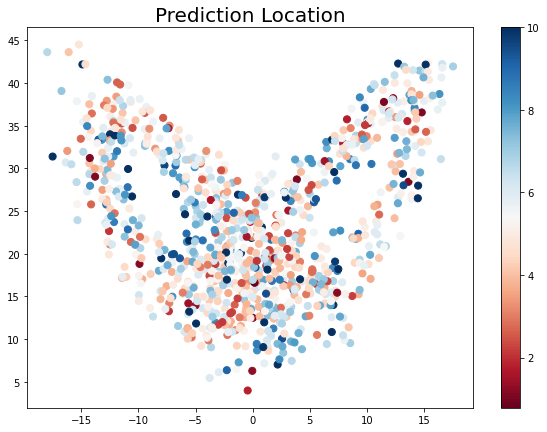

In [45]:
colors = np.copy(pred)
colors[colors > 10] = 10
fig = plt.figure(figsize = (10, 7))
plt.scatter(x[:, 0], x[:, 2], s = 50, c = colors, cmap = 'RdBu')
plt.colorbar()
plt.title('Prediction Location', fontsize = 20)
fig.savefig('prediction.pdf', bbox_inches = 'tight')

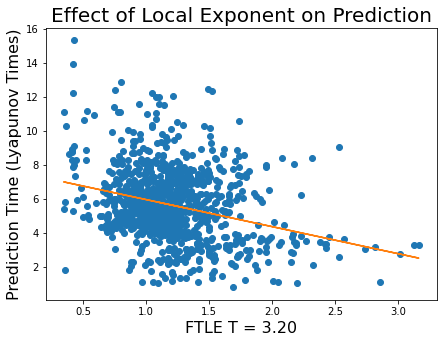

In [43]:
fig = plt.figure(figsize = (7, 5))
xle = LE[:, 0]
yle = pred


plt.plot(xle, yle, 'o')
m, b = np.polyfit(xle, yle, 1)
plt.plot(xle, m*xle+b)
plt.xlabel('FTLE T = {:1.2f}'.format(T), fontsize = 16)
plt.ylabel('Prediction Time (Lyapunov Times)', fontsize = 16)
plt.title('Effect of Local Exponent on Prediction', fontsize = 20)
fig.savefig('FTLE_prediction.pdf', bbox_inches = 'tight')

In [14]:
# for l in L:
#     T = l*dt
#     LE = lor63sys.localExp(x, l, dt, multi = False)
#     fig = plt.figure(figsize = (7, 5))
#     plt.plot(diff*np.exp(LE[:, 0]*T), pred, 'o')
#     plt.xscale('log')
#     plt.xlabel('diff exp(lambda t)', fontsize = 16)
#     plt.ylabel('Prediction Time (Lyapunov Times)', fontsize = 16)
#     plt.title('Effect of Local Exponent on Prediction', fontsize = 20)
# #     fig.savefig('FTLE_prediction_T{:1.2f}.pdf'.format(T), bbox_inches = 'tight')

The mean prediction time is 5.63 with std 2.10


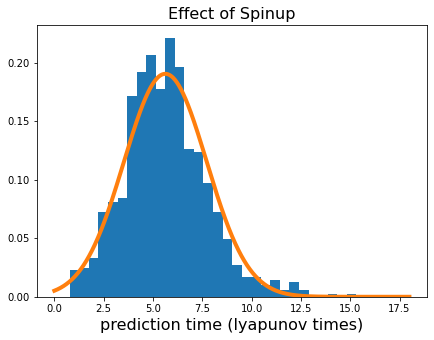

In [46]:
fig = plt.figure(figsize = (7, 5))
plt.hist(pred, density = True, bins = 30)
plt.title('Effect of Spinup', fontsize = 16)

# find minimum and maximum of xticks, so we know
# where we should compute theoretical distribution
xt = plt.xticks()[0]  
xmin, xmax = min(xt), max(xt)  
lnspc = np.linspace(xmin, xmax, len(pred))

# lets try the normal distribution
m, s = stats.norm.fit(pred) # get mean and standard deviation  
pdf_g = stats.norm.pdf(lnspc, m, s) # now get theoretical values in our interval  
plt.plot(lnspc, pdf_g, label="Norm", lw = 4) # plot it
plt.xlabel('prediction time (lyapunov times)', fontsize = 16)
print('The mean prediction time is {:1.2f} with std {:1.2f}'.format(m, s))
fig.savefig('results/spinup_variation.pdf', bbox_inches = 'tight')

In [26]:
np.max(pred)

15.304770318021202